In [ ]:
# Imports and defaults
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

mpl.rcParams["figure.figsize"] = [6, 4]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["errorbar.capsize"] = 3
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 10

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.10.12
matplotlib 3.7.1


In [ ]:
class GaussBandit(object):
  def __init__(self, mu, sigma=0.5):
    self.mu = np.copy(mu)
    self.K = self.mu.size
    self.sigma = sigma
    self.best_arm = np.argmax(self.mu)
    self.randomize()

  def randomize(self):
    # generate random rewards
    # randn = random from mean 0, std 1 normal distribution
    self.rt = self.mu + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
     # print mean reward of all arms
    return "Gaussian bandit with arms (%s)" % \
      ", ".join("%.3f" % s for s in self.mu)

In [ ]:
def evaluate_one(Alg, params, env, expert_fraction, n, period_size=1):
  """One run of a bandit algorithm."""
  '''
  Run alg on env using params for T=n
  Return an array 1 x n of regrets
  And the trained algorithm
  '''
  alg = Alg(env, n, params, expert_fraction)
  regret = np.zeros(n // period_size)
  for t in range(n):
    # generate state
    env.randomize()

    # take action
    arm = alg.get_arm(t)

    # update model and regret
    alg.update(t, arm, env.reward(arm))
    regret_at_t = env.regret(arm)
    regret[t // period_size] += regret_at_t

  return regret, alg

def evaluate(Alg, params, env, expert_fraction, n=1000, period_size=1, printout=True):

  """Multiple runs of a bandit algorithm."""
  '''
  Run the algorithm for all environments in env
  Returns array of size env x n with instantaneous regrets
  and alg array of trained algorithms
  '''
  if printout:
    print("Evaluating %s" % Alg.print(), end="")
  start = time.time()

  num_exps = len(env)
  regret = np.zeros((n // period_size, num_exps))
  alg = num_exps * [None]
  # dots used only to keep track of progress!
  dots = np.linspace(0, num_exps - 1, 100).astype(int)
  for ex in range(num_exps):
    output = evaluate_one(Alg, params, env[ex], expert_fraction, n, period_size)
    regret[:, ex] = output[0]
    alg[ex] = output[1]
    # progress print every 1% of completed experiments
    if ex in dots:
      if printout:
        print(".", end="")
  if printout:
    print(" %.1f seconds" % (time.time() - start))

  if printout:
    total_regret = regret.sum(axis=0)
    print("Regret: %.2f +/- %.2f (median: %.2f, max: %.2f, min: %.2f)" %
      (total_regret.mean(), total_regret.std() / np.sqrt(num_exps),
      np.median(total_regret), total_regret.max(), total_regret.min()))
  return regret, alg

In [ ]:
class UCB_Optimism:
  def __init__(self, env, n, params, expert_fraction):
    # history is an array of percentage values
    # history[arm] = percentage of time expert played arm
    self.K = env.K
    self.sigma = 0.5
    self.expert_fraction = np.array(expert_fraction)

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = 1e-6 * np.ones(self.K)  # number of pulls
    self.reward = np.zeros(self.K)  # cumulative reward
    # rand is the uniform distribution [0,1]
    self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    # UCBs
    t += 1  # time starts at one
    ciw = sigma * np.sqrt(8 * np.log(t))
    self.ucb = self.reward / self.pulls + \
      ciw * np.sqrt(1 / self.pulls) #+ self.tiebreak
    if t <= 50:
        arm = np.argmax(self.ucb)
    else:
        avg_observed_reward = self.reward / self.pulls
        pull_fraction = self.pulls / sum(self.pulls)
        avg_label_reward = self.ucb
        use_reward = (expert_fraction * avg_label_reward + pull_fraction * avg_observed_reward)\
                    / (expert_fraction + pull_fraction)
        self.ucb_optimistic = use_reward + \
            ciw * np.sqrt(1 / self.pulls) #+ self.tiebreak
        arm = np.argmax(self.ucb_optimistic)
    return arm

  @staticmethod
  def print():
    return "UCB_Optimism"


class UCB:
  def __init__(self, env, n, params, expert_fraction):
    self.K = env.K
    self.sigma = 0.5

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = 1e-6 * np.ones(self.K)  # number of pulls
    self.reward = np.zeros(self.K)  # cumulative reward
    self.tiebreak = 1e-6 * np.random.rand(self.K)  # tie breaking

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    # UCBs
    t += 1  # time starts at one
    ciw = sigma * np.sqrt(8 * np.log(t))
    self.ucb = self.reward / self.pulls + \
      ciw * np.sqrt(1 / self.pulls) #+ self.tiebreak

    arm = np.argmax(self.ucb)
    return arm

  @staticmethod
  def print():
    return "UCB"


Evaluating UCB.................................................................................................... 28.0 seconds
Regret: 170.11 +/- 4.78 (median: 161.14, max: 300.25, min: 88.40)
Evaluating UCB_Optimism.................................................................................................... 46.6 seconds
Regret: 137.66 +/- 3.43 (median: 136.96, max: 224.35, min: 48.44)


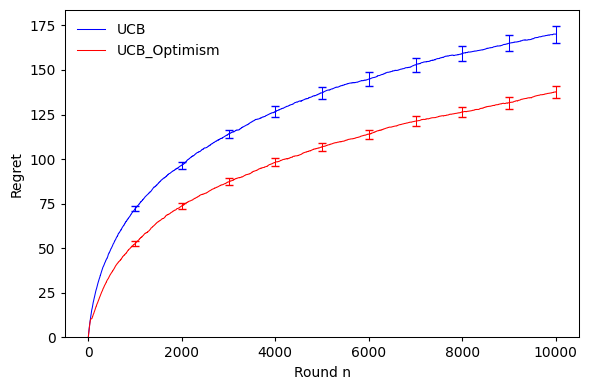

In [ ]:
# Single task with expert
K = 5
sigma = 0.5
n = 10000
num_runs = 100
expert_fraction = [1, 0, 0, 0, 0]

algs = [("UCB", {"sigma": sigma}, "blue", "-", "UCB"),
        ("UCB_Optimism", {"sigma": sigma}, "red", "-", "UCB_Optimism")]

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

envs = []
for run in range(num_runs):
  indices = [0, 1, 2, 3, 4]
  index = np.random.choice(indices, 1, p=expert_fraction)
  mu = np.random.rand(K)
  max_ind = np.argmax(mu)
  mu[max_ind], mu[index] = mu[index], mu[max_ind]
  envs.append(GaussBandit(mu, sigma=sigma))


for alg in algs:
  alg_class = globals()[alg[0]]
  regret, _ = evaluate(alg_class, alg[1], envs, expert_fraction, n)

  cum_regret = regret.cumsum(axis=0)
  plt.plot(step, cum_regret.mean(axis=1),
    alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
  plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
    cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
    fmt="none", ecolor=alg[2])

plt.xlabel("Round n")
plt.ylabel("Regret")
plt.ylim(bottom=0)
plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig('MAB_sigma=10.png')
plt.show()

Evaluating UCB.................................................................................................... 20.1 seconds
Regret: 160.62 +/- 4.65 (median: 156.82, max: 276.79, min: -31.07)
Evaluating UCB_Optimism.................................................................................................... 42.2 seconds
Regret: 403.31 +/- 7.97 (median: 396.53, max: 623.65, min: 172.72)


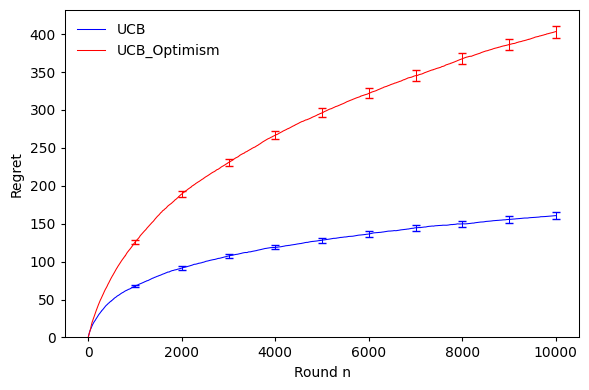

In [ ]:
# Multiple tasks expert
K = 5
sigma = 0.5
n = 10000
num_runs = 100
expert_fraction = [0.05, 0.05, 0.1, 0.5, 0.3]

algs = [("UCB", {"sigma": sigma}, "blue", "-", "UCB"),
        ("UCB_Optimism", {"sigma": sigma}, "red", "-", "UCB_Optimism")]

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

envs = []
for run in range(num_runs):
  indices = [0, 1, 2, 3, 4]
  index = np.random.choice(indices, 1, p=expert_fraction)
  mu = np.random.rand(K)
  max_ind = np.argmax(mu)
  mu[max_ind], mu[index] = mu[index], mu[max_ind]
  envs.append(GaussBandit(mu, sigma=sigma))


for alg in algs:
  alg_class = globals()[alg[0]]
  regret, _ = evaluate(alg_class, alg[1], envs, expert_fraction, n)

  cum_regret = regret.cumsum(axis=0)
  plt.plot(step, cum_regret.mean(axis=1),
    alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
  plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
    cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
    fmt="none", ecolor=alg[2])

plt.xlabel("Round n")
plt.ylabel("Regret")
plt.ylim(bottom=0)
plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig('MAB_sigma=10.png')
plt.show()

Evaluating UCB.................................................................................................... 20.8 seconds
Regret: 173.23 +/- 4.87 (median: 172.08, max: 324.24, min: 80.69)
Evaluating UCB_Optimism.................................................................................................... 43.3 seconds
Regret: 465.16 +/- 6.75 (median: 456.04, max: 606.10, min: 324.26)


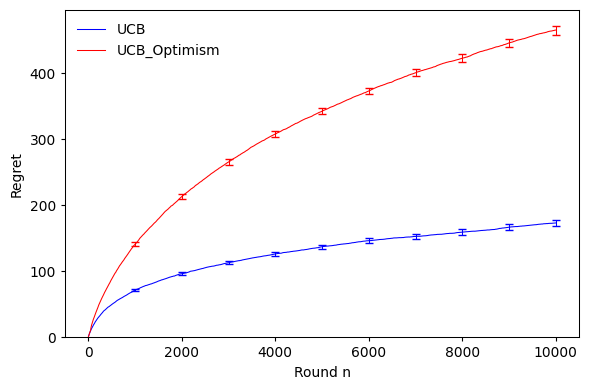

In [ ]:
# Non-informative prior
K = 5
sigma = 0.5
n = 10000
num_runs = 100
expert_fraction = [0.2, 0.2, 0.2, 0.2, 0.2]

algs = [("UCB", {"sigma": sigma}, "blue", "-", "UCB"),
        ("UCB_Optimism", {"sigma": sigma}, "red", "-", "UCB_Optimism")]

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

envs = []
for run in range(num_runs):
  indices = [0, 1, 2, 3, 4]
  index = np.random.choice(indices, 1, p=expert_fraction)
  mu = np.random.rand(K)
  max_ind = np.argmax(mu)
  mu[max_ind], mu[index] = mu[index], mu[max_ind]
  envs.append(GaussBandit(mu, sigma=sigma))


for alg in algs:
  alg_class = globals()[alg[0]]
  regret, _ = evaluate(alg_class, alg[1], envs, expert_fraction, n)

  cum_regret = regret.cumsum(axis=0)
  plt.plot(step, cum_regret.mean(axis=1),
    alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
  plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
    cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
    fmt="none", ecolor=alg[2])

plt.xlabel("Round n")
plt.ylabel("Regret")
plt.ylim(bottom=0)
plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig('MAB_sigma=10.png')
plt.show()